## Import necessary libraries 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import pickle

## Load the dataset

In [21]:
# Load the dataset
movies_file = "./ml-latest-small/movies.csv"  # Update with your file path
ratings_file = "./ml-latest-small/ratings.csv"  # Update with your file path

movies_df = pd.read_csv(movies_file)
ratings_df = pd.read_csv(ratings_file)

## Data Preprocessing

In [22]:
# Add a popularity metric and average rating to the movies dataset
movie_ratings_count = ratings_df.groupby('movieId').size().rename("rating_count")
average_ratings = ratings_df.groupby('movieId')['rating'].mean().rename("rating")

movies_df = movies_df.merge(movie_ratings_count, on="movieId", how="left")
movies_df = movies_df.merge(average_ratings, on="movieId", how="left")

# Fill missing ratings and counts with default values
movies_df['rating'] = movies_df['rating'].fillna(0)
movies_df['rating_count'] = movies_df['rating_count'].fillna(0)

# Extract release year from title if available
if 'release_year' not in movies_df.columns:
    print("Extracting release year from title...")
    movies_df['release_year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)
    movies_df['release_year'] = movies_df['release_year'].fillna(0).astype(int)

movies_file = "movies1.csv"
# Save the updated DataFrame back to the CSV file
movies_df.to_csv(movies_file, index=False)
print(f"Updated 'movies.csv' with 'release_year' column.")

Extracting release year from title...
Updated 'movies.csv' with 'release_year' column.


## Data Visualization

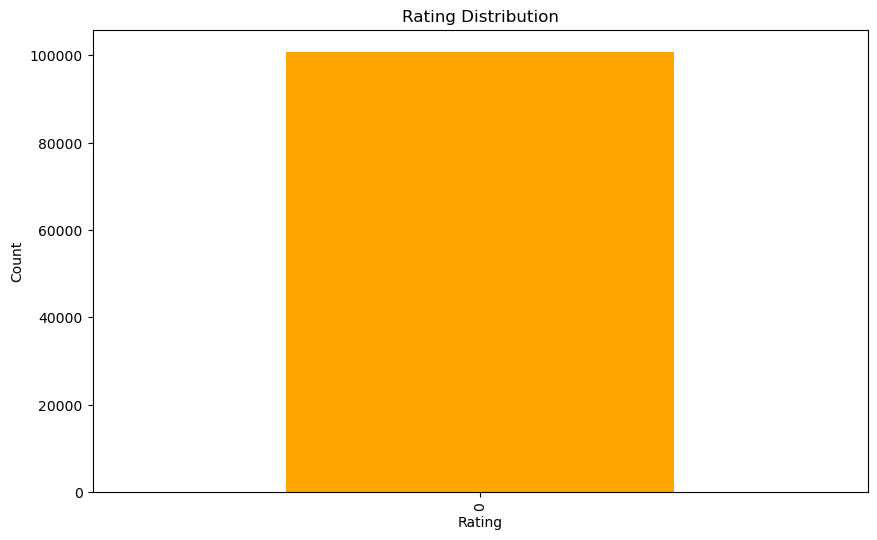

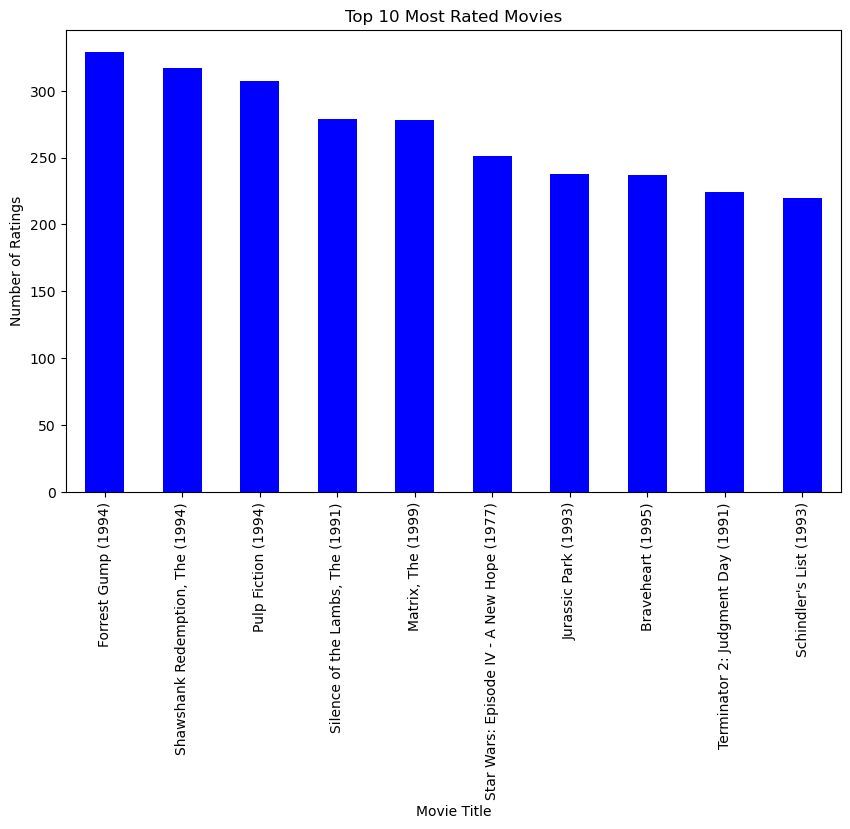

In [23]:
# Merge movies and ratings for visualization
merged_df = pd.merge(ratings_df, movies_df, on="movieId", how="inner")

# Ensure the 'rating' column exists and fill missing values
if 'rating' not in merged_df.columns:
    print("Warning: 'rating' column is missing. Adding it.")
    merged_df['rating'] = 0
merged_df['rating'] = merged_df['rating'].fillna(0)

# Visualize the distribution of ratings
plt.figure(figsize=(10, 6))
if 'rating' in merged_df.columns:
    merged_df['rating'].value_counts().sort_index().plot(kind='bar', color='orange')
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()
else:
    print("Error: 'rating' column not available for visualization.")

# Visualize the most rated movies
if 'title' in merged_df.columns:
    top_movies = merged_df['title'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    top_movies.plot(kind='bar', color='blue')
    plt.title("Top 10 Most Rated Movies")
    plt.xlabel("Movie Title")
    plt.ylabel("Number of Ratings")
    plt.show()
else:
    print("Error: 'title' column not available for visualization.")

## Model Training

In [24]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Model Training
svd = SVD(n_factors=50, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)

## Model Evaluation 

In [25]:
# Evaluate the model
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"Model RMSE: {rmse}")
print(f"Model MAE: {mae}")

RMSE: 0.8765
MAE:  0.6732
Model RMSE: 0.8764979910580851
Model MAE: 0.6732189016363566


## Saving the model and evaluating

In [33]:
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
train_rmse = cv_results['test_rmse']
train_mae = cv_results['test_mae']
# Save the model
with open('svd_model_13_dec_2024.pkl', 'wb') as f:
    pickle.dump(svd, f)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8687  0.8674  0.8746  0.8730  0.8652  0.8698  0.0035  
MAE (testset)     0.6664  0.6666  0.6701  0.6697  0.6655  0.6677  0.0019  
Fit time          0.98    0.97    1.05    1.02    1.11    1.03    0.05    
Test time         0.27    0.23    0.25    0.23    0.21    0.24    0.02    


In [34]:
# Enhanced Genre-Based Recommendations
def recommend_genres(selected_genres, rating_min=0, rating_max=5, year_min=2000):
    # Filter movies by genres
    filtered_movies = movies_df[movies_df['genres'].apply(lambda x: any(genre in x for genre in selected_genres))]

    # Apply additional filters: ratings
    filtered_movies = filtered_movies[(filtered_movies['rating'] >= rating_min) & (filtered_movies['rating'] <= rating_max)]

    # Apply additional filter: release year (after 2000 by default)
    filtered_movies = filtered_movies[filtered_movies['release_year'] >= year_min]

    # Rank movies by popularity and rating
    filtered_movies = filtered_movies.sort_values(by=['rating_count', 'rating'], ascending=[False, False])

    # Use collaborative filtering (SVD) to predict scores for filtered movies
    predictions = [(movie_id, svd.predict(0, movie_id).est) for movie_id in filtered_movies['movieId']]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]

    recommended_movie_ids = [movie_id for movie_id, _ in predictions]
    recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]

    return recommended_movies[['title', 'genres', 'rating', 'release_year']]

In [35]:
# Example Usage
selected_genres = ['Action', 'Comedy']
recommended_movies = recommend_genres(selected_genres, rating_min=4.0, rating_max=5.0, year_min=2000)

print("Recommended Movies:")
print(recommended_movies)

Recommended Movies:
                                                  title  \
2462                        Boondock Saints, The (2000)   
2996                                      Snatch (2000)   
3622  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...   
4529                         Lost in Translation (2003)   
4800  Lord of the Rings: The Return of the King, The...   
5335                           Shaun of the Dead (2004)   
6016                         Kiss Kiss Bang Bang (2005)   
6676                                   In Bruges (2008)   
6710                            Dark Knight, The (2008)   
7355                                 Toy Story 3 (2010)   

                                                genres    rating  release_year  
2462                       Action|Crime|Drama|Thriller  4.220930          2000  
2996                             Comedy|Crime|Thriller  4.155914          2000  
3622                                    Comedy|Romance  4.183333          2001  
4529  